#GAN MONKEY, THAT FUNKY MONKEY

<img src="https://media.newyorker.com/photos/61016c1c7a2a603b3075c7b8/master/w_2560%2Cc_limit/chayka-boredapeclub.jpg">

##Generative Adversarial Network (GAN)

GAN's are a type of neural network architecture which uses 2 seperate networks to generate some kind of data, whether that be images or text. These 2 networks are called the Discriminator and the Generator. 

<img src="https://www.researchgate.net/publication/349182009/figure/fig2/AS:1021198364327941@1620484071612/Typical-Generative-Adversarial-Networks-GAN-architecture.png">

###Generator

The generator, which you may be able to tell by the name, is what creates the data from learned patterns. If you are familiar with auto-encoder architecture like with seq2seq for example, you know that the goal of those models is to take some kind of data such as a sentence and turn it into a 1d vector representation in the latent space. What this essentially means is that the patterns from the data are getting turned into a single number representation. Now imagine this the other way around, where instead of taking n-dimensional data and turning it into 1-dimensional data we take 1-dimenstional data and expand it into n-dimensional data. By pairing this idea with a network trained for this and random noise as the input, we can create new random data. But how do we train a model.

###Discriminator

The discriminators job in this architecture is to help train the generator. First the generator creates data from random noise, and the data is mixed in with real data. This data is then given to the discriminator which will discern which data is real and fake and compute an error, which is used to train both the generator and discriminator. 

##GAN Stability 

The 2 network architecture which makes GANs so special is also what makes them unstable. The 2 networks in a GAN have to be trained evenly. What I mean by this is that if the Discriminator at any point begins outperforming the Generator, the Generator will constantly have a high error and will not learn. If the Generator outperforms the Discriminator, it will always have a low error and will not learn. This is what makes GANs very finicky to work with.

On top of this GANs still have all of the same issues as the networks that they are built with such as exploding/vanishing gradient.

##Loss Functions

Loss functions in GANs can make a huge difference. That is why there are so many different types of GANs. Let's talk about some of them.

###WGAN (Wasserstein Loss Function)

Wasserstein loss function aims to fix some of the problems that come from using a regular cross_entropy_loss() GAN. Regular GAN's have big issues with vanishing gradients. To stabilize the GAN wasserstein aims to increase the gap between scores for the real and fake images to prevent. If you ever run into problems of your GAN not training, or performance collapsing after n amount of epochs, then try using a WGAN.

##LSGAN (Least Squares Loss Function)

Least Squares aims to do the same thing by using the MSE loss function. This is the one that we will be using in this workshop. It is much easier to impliment than the WGAN and performs pretty well.

##Prepare Data

In [ ]:
import tensorflow as tf
from tensorflow.data.experimental import AUTOTUNE
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

This is just a work around if you get a problem where the git repo doesn't update. Simply remove the files and try again.

In [ ]:
!rm -r NFT_GAN

The important data in the repo is the images. We will be using 2000 images of bored_apes. Note that there are no labels, this is because we won't be classifying or making predictions based on images but generating images and classifying whether an image is real or fake.

In [ ]:
!git clone https://github.com/utkML/NFT_GAN.git

Cloning into 'NFT_GAN'...
remote: Enumerating objects: 4020, done.
remote: Counting objects: 100% (2011/2011), done.
remote: Compressing objects: 100% (2010/2010), done.
remote: Total 4020 (delta 1), reused 2010 (delta 0), pack-reused 2009
Receiving objects: 100% (4020/4020), 115.93 MiB | 23.24 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
BATCH_SIZE = 64
IMAGE_SIZE = 128  # reduce this to increase performance
IMAGE_CHANNELS = 3  # can be 3 (RGB) or 1 (Grayscale)
LATENT_SPACE_DIM = 100  # dimensions of the latent space that is used to generate the images

In [ ]:
train_url = '/content/NFT_GAN/NFT_dataset'

Unfortunately we can't use the tensorflow import library to import images as a dataset because it will be imported as a tensorflow dataset object. We don't want this since it is difficult to setup with the GAN. Instead we can import the images manually and turn them into a numpy array. This will make it much easier to manage the array shapes of our images.

In [ ]:
IMAGE_SIZE = 256
assert IMAGE_SIZE % 4 == 0


def preprocess(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_CHANNELS)
    img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
    # scale between [-1,1]
    img = (img - 127.5) / 127.5
    return img


def filter(img):
    return img[0, 0, 0] == -1  # discard white bg images (estimate by the R channel of the top left pixel)


def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.filter(filter)
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds


list_ds = tf.data.Dataset.list_files(str('/content/NFT_GAN/NFT_dataset/*/*'), shuffle=True)  # Get all images from subfolders
train_dataset = list_ds.take(-1)
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_dataset = train_dataset.map(preprocess, num_parallel_calls=AUTOTUNE)
train_dataset = configure_for_performance(train_dataset)


##Build GAN

Now that we have our data, we can start constructing our gan. Remember that our GAN is made of 2 different neural networks a generator, and a discriminator. Since we are using a GAN to perform on images we will be using CNN architecture in both networks.

Our generator will take in random noise from a latent space. Then we will upscale it using a feature map. This is essentially a normal CNN but in reverse. To do this upscaling we will use the Conv2D transpose layers. This learns a featuremap over time and upscales it to create an image. Everything else is pretty standard for a network.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    
    n = IMAGE_SIZE // 4
    
    model.add(layers.Dense(n * n * 256, use_bias=False, input_shape=(LATENT_SPACE_DIM,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((n, n, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

Our descriminator model is a basic CNN. Think back to when we classified Chihuahuas and Muffins. Instead here we will be classifying a fake vs real image.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS)))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model



Now similar to other networks we have made we will be using a basic Adam optimizer and will then build our networks by calling the functions we created earlier.

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator = make_discriminator_model()
generator = make_generator_model()

This is the part that seperates an LSGAN from other GANs. Here we will setup the MSE loss function as opposed to a BinaryCrossentropy loss function. This should improve how our model performs.

In [ ]:
from tensorflow.keras.losses import MeanSquaredError
MSE = MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = MSE(tf.ones_like(real_output), real_output)
    fake_loss = MSE(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return MSE(tf.ones_like(fake_output), fake_output)



Now we need to define how the models will train. We cannot simply call a train function because we have 2 networks working in tandem. So we will need to write a few functions to control both.

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_SPACE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



To view how our model is training we can generate a number of images every n amount of epochs, using our currently training generator.

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        if predictions.shape[-1] == 3:
            plt.imshow(predictions[i] * 0.5 + .5)
        else: 
            plt.imshow(predictions[i, :, :, 0] * 0.5 + .5, cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()



Now we can create a train function. In it we will call our train_step every epoch to update our model.

In [ ]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, LATENT_SPACE_DIM])

def train(dataset, epochs, save_after):
    
    generate_and_save_images(generator, 0, seed)
    
    for epoch in range(epochs):
        for image_batch in dataset:
            train_step(image_batch)

        if (epoch + 1) % save_after == 0:
            display.clear_output(wait=True)
            generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    display.clear_output(wait=True)
    generate_and_save_images(generator,
                       epochs,
                       seed)

In [ ]:
!mkdir images

mkdir: cannot create directory ‘images’: File exists


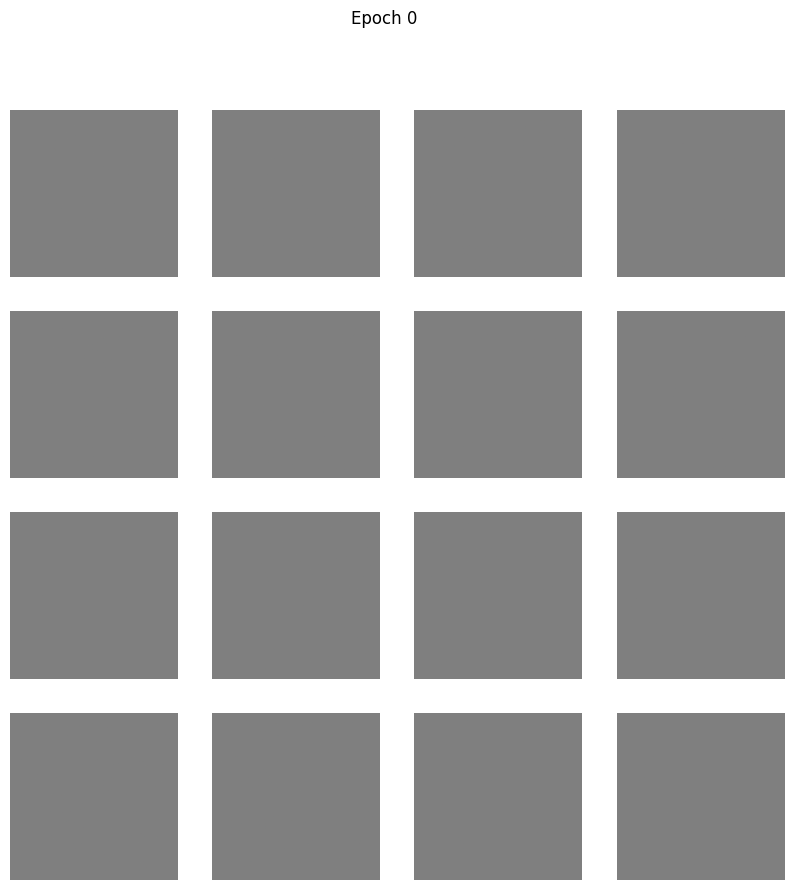

In [ ]:
train(train_dataset, epochs=1000, save_after=10)

The code below is used to turn our images into a GIF. I don't know too much about these image libraries so I got this from StackOverflow. Thank you StackOverflow.

In [ ]:
import glob
import contextlib
from PIL import Image
from IPython.display import Image as IMAGE

# filepaths
fp_in = "/content/images/*"
fp_out = "ganimation.gif"

# use exit stack to automatically close opened images
with contextlib.ExitStack() as stack:

    # lazily load images
    imgs = (stack.enter_context(Image.open(f))
            for f in sorted(glob.glob(fp_in)))

    # extract  first image from iterator
    img = next(imgs)

    # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
    img.save(fp=fp_out, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)

In [ ]:
IMAGE(open('ganimation.gif','rb').read())